### data loading

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df=pd.DataFrame(
    columns = ['build_Failed', 'gh_is_pr', 'git_prev_commit_resolution_status',
       'gh_team_size', 'gh_num_commit_comments', 'git_diff_src_churn',
       'git_diff_test_churn', 'gh_diff_files_added', 'gh_diff_files_deleted',
       'gh_diff_files_modified', 'gh_diff_tests_added',
       'gh_diff_tests_deleted', 'gh_diff_src_files', 'gh_diff_doc_files',
       'gh_diff_other_files', 'gh_sloc', 'gh_test_lines_per_kloc',
       'gh_test_cases_per_kloc', 'gh_asserts_cases_per_kloc', 'tr_build_id',
       'gh_build_started_at'],
    dtype='object')

path = '/mnt/d/PFE/Code/CI-Failing-Builds-Detection/dataset'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename[-4:]==".csv":
            df = pd.concat([df, pd.read_csv(os.path.join(dirname, filename))])

In [6]:
X = df.iloc[:,1:19]
y = df.iloc[:,0].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y) # keep ratio of classes in split

### modifying trees

#### Documentation
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py


In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
dt = DecisionTreeClassifier(max_depth=3, splitter='random').fit(X_train, y_train)

#### Displaying the tree

In [9]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples\n"
        rules += [rule]
        
    return rules

rules = get_rules(dt, list(df.columns), ['pass','fail'])
for r in rules:
    print(r)



if (gh_test_cases_per_kloc > 24.978) and (gh_test_lines_per_kloc <= 143.531) and (gh_sloc > 320.187) then class: pass (proba: 68.89%) | based on 33,948 samples

if (gh_test_cases_per_kloc > 24.978) and (gh_test_lines_per_kloc > 143.531) and (git_prev_commit_resolution_status > 154.66) then class: pass (proba: 65.48%) | based on 15,513 samples

if (gh_test_cases_per_kloc > 24.978) and (gh_test_lines_per_kloc > 143.531) and (git_prev_commit_resolution_status <= 154.66) then class: fail (proba: 65.01%) | based on 7,853 samples

if (gh_test_cases_per_kloc <= 24.978) and (gh_sloc <= 27.994) and (gh_is_pr > 1.107) then class: pass (proba: 93.74%) | based on 4,106 samples

if (gh_test_cases_per_kloc <= 24.978) and (gh_sloc > 27.994) and (gh_sloc <= 119.531) then class: pass (proba: 70.47%) | based on 3,451 samples

if (gh_test_cases_per_kloc <= 24.978) and (gh_sloc <= 27.994) and (gh_is_pr <= 1.107) then class: pass (proba: 90.09%) | based on 3,047 samples

if (gh_test_cases_per_kloc <= 24.97

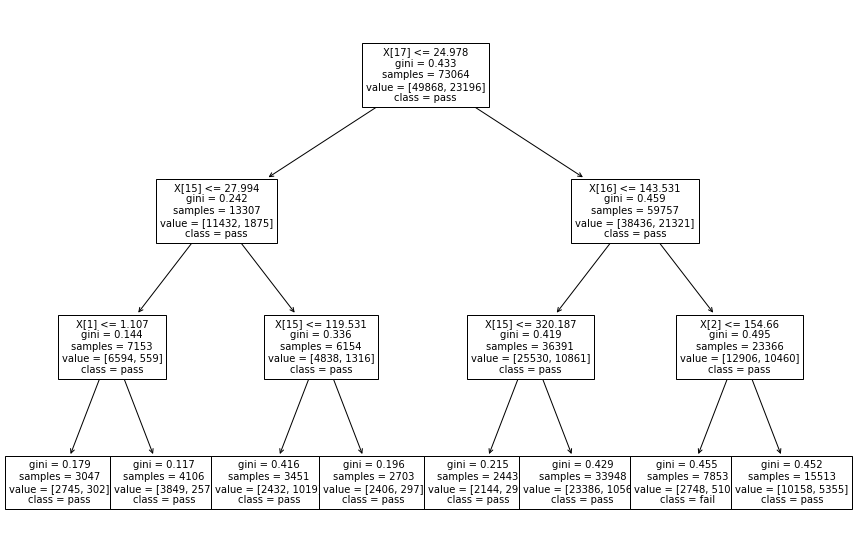

In [10]:
from sklearn import tree

# plot tree
plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
tree.plot_tree(dt, fontsize=10, class_names=['pass','fail'])
plt.show()

#### Methods

In [11]:
print(dt.tree_.node_count)    # nbr nodes
print(dt.tree_.feature)       # list of features, one feature for each node
print(dt.tree_.threshold)     # All the thresholds

dt.tree_.threshold[3] = 10.0  # Manually modifying a threshold   

15
[17 15  1 -2 -2 15 -2 -2 16 15 -2 -2  2 -2 -2]
[ 24.97750485  27.99439603   1.10658618  -2.          -2.
 119.53080164  -2.          -2.         143.53079561 320.18734448
  -2.          -2.         154.65995602  -2.          -2.        ]


In [13]:
dt.tree_.children_left[0] # children_left[i]: id of the left child of node i or -1 if leaf node
# DFS traversal 

1

children_left[i]: id of the left child of node i or -1 if leaf node

children_right[i]: id of the right child of node i or -1 if leaf node

feature[i]: feature used for splitting node i

threshold[i]: threshold value at node i

n_node_samples[i]: the number of of training samples reaching node i

impurity[i]: the impurity at node 

In [14]:
clf = dt
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
feature_name = [list(df.columns)[i] for i in feature]
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[i, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature_name[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[i, gh_test_cases_per_kloc] <= 24.977504850303774 else to node 8.
	node=1 is a split node: go to node 2 if X[i, gh_sloc] <= 27.99439603418648 else to node 5.
		node=2 is a split node: go to node 3 if X[i, gh_is_pr] <= 1.1065861802113177 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[i, gh_sloc] <= 119.53080164388962 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[i, gh_test_lines_per_kloc] <= 143.53079561258755 else to node 12.
		node=9 is a split node: go to node 10 if X[i, gh_sloc] <= 320.18734448133887 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[i, git_prev_commit_resolution_status] <= 154.65995601688508 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf 

In [15]:
for name, importance in zip(feature_name, dt.feature_importances_):
    print(name, importance)

gh_test_cases_per_kloc 0.0
gh_sloc 0.001550013758180737
gh_is_pr 0.32196059499280955
tr_build_id 0.0
tr_build_id 0.0
gh_sloc 0.0
tr_build_id 0.0
tr_build_id 0.0
gh_test_lines_per_kloc 0.0
gh_sloc 0.0
tr_build_id 0.0
tr_build_id 0.0
git_prev_commit_resolution_status 0.0
tr_build_id 0.0
tr_build_id 0.0


In [16]:
from sklearn.metrics import f1_score 
f1_score(dt.predict(X_val),y_val)

0.33086923273005353

In [17]:
for i in range(dt.tree_.node_count):
    dt.tree_.threshold[i] = 0.0  # Manually modifying a threshold   
f1_score(dt.predict(X_val),y_val)

0.002049880423641954

#### modDT class

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import f1_score 

class modDecisionTree:
    """
    Represents the classification model
    based on sklearn implementation with added methods for modifying single nodes
    nodes are indexed depth first
    """

    def __init__(self, max_depth=3, random_state=42):
        # need to add init of hyper-param
        self.model = DecisionTreeClassifier(max_depth=max_depth, splitter='random', random_state=random_state)
    
    def fit(self, X_train, y_train, columns_names):
        self.model.fit(X_train, y_train)
        self.tree = self.model.tree_
        self.n_nodes = self.tree.node_count      # nbr nodes
        self.features = self.tree.feature         # list of each node's feature
        self.thresholds = self.tree.threshold     # list of each node's threshold
        self.columns_names = columns_names
        self.features_names = [list(self.columns_names)[i] for i in self.features]
        self.nodes_type = self.get_nodes_type()  # a node is either a split node or a terminal node/leaf

    def evaluate(self, X_val, y_val):
        y_pred = self.model.predict(X_val)
        metrics = {}
        metrics['F1'] = f1_score(y_pred ,y_val)
        return metrics

    def feature_importance(self):
        feat_imp = []
        for name, importance in zip(self.features_names , self.model.feature_importances_):
            feat_imp.append((name, importance))
        feat_imp.sort(key=lambda t:t[1], reverse=True)
        return feat_imp

    def plot_tree(self):
        plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
        tree.plot_tree(self.model, fontsize=10, class_names=['pass','fail'])
        plt.show()
    
    def get_nodes_type(self):
        children_left = self.tree.children_left
        children_right = self.tree.children_right
        node_depth = np.zeros(shape=self.n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=self.n_nodes, dtype=bool)
        stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
        while len(stack) > 0:
            # 'pop' ensures each node is only visited once
            node_id, depth = stack.pop()
            node_depth[node_id] = depth
            # If the left and right child of a node is not the same we have a split node
            is_split_node = children_left[node_id] != children_right[node_id]
            # If a split node, append left and right children and depth to `stack`
            # so we can loop through them
            if is_split_node:
                stack.append((children_left[node_id], depth + 1))
                stack.append((children_right[node_id], depth + 1))
            else:
                is_leaves[node_id] = True
        return is_leaves

    def node_is_leaf(self, node):
        """Returns whether a node is a leaf (terminal node) or a split node"""
        return self.nodes_type[node]==1

    def set_node_threshold(self, node, value):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a leaf node's threshold.")
            return
        self.threshold[node] = value 

    def set_node_feature(self, node, feat_index=None, feat_name=None):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a terminal node's feature.")
            return
        # convert feature name to index if supplied with name
        if feat_index==None:
            feat_index = self.features_names.index(feat_name)
        self.features[node] = feat_index

[ 2.28869427e+03  3.48991342e+02  2.00350280e+01 -2.00000000e+00
 -2.00000000e+00  1.02874747e+02 -2.00000000e+00 -2.00000000e+00
  6.99941550e+02  1.47960611e+05 -2.00000000e+00 -2.00000000e+00
  4.07375903e+01 -2.00000000e+00 -2.00000000e+00]
[False False False  True  True False  True  True False False  True  True
 False  True  True]


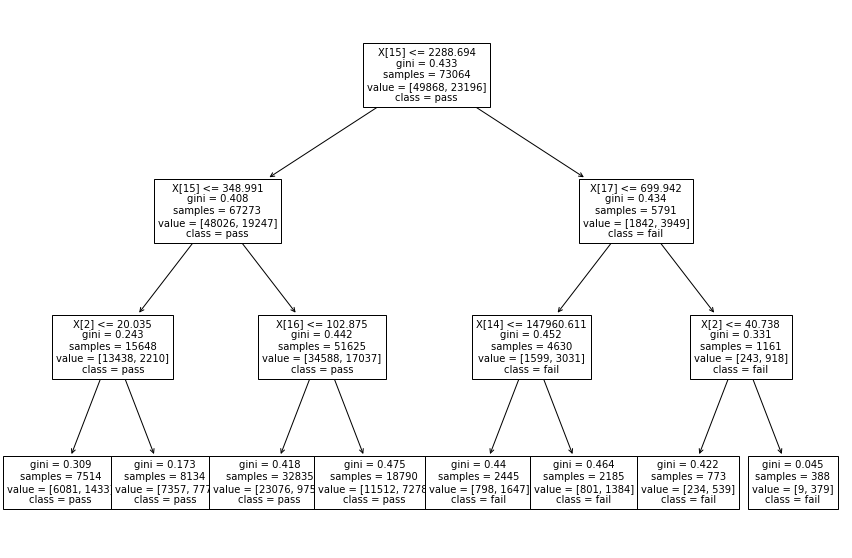

{'F1': 0.2678251275686112}
Error: can't change a leaf node's threshold.


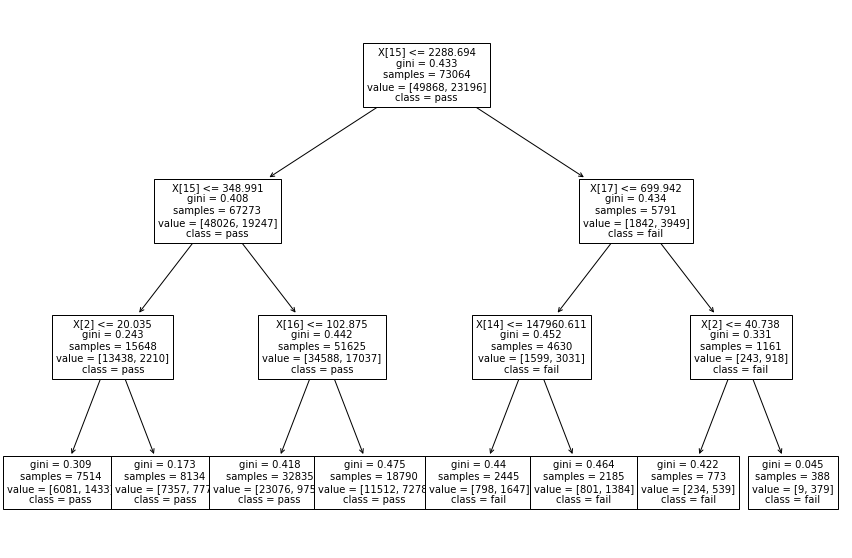

{'F1': 0.2678251275686112}
Error: selected node id is not in the tree.


In [29]:
model = modDecisionTree()
model.fit(X_train,y_train, df.columns)
print(model.thresholds)
print(model.get_nodes_type())
model.features
model.node_is_leaf(0)
model.plot_tree()
print(model.evaluate(X_val,y_val))
model.set_node_threshold(3,-1)
model.plot_tree()
print(model.evaluate(X_val,y_val))
model.set_node_threshold(99,-1)

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.DataFrame(
    columns = ['build_Failed', 'gh_is_pr', 'git_prev_commit_resolution_status',
       'gh_team_size', 'gh_num_commit_comments', 'git_diff_src_churn',
       'git_diff_test_churn', 'gh_diff_files_added', 'gh_diff_files_deleted',
       'gh_diff_files_modified', 'gh_diff_tests_added',
       'gh_diff_tests_deleted', 'gh_diff_src_files', 'gh_diff_doc_files',
       'gh_diff_other_files', 'gh_sloc', 'gh_test_lines_per_kloc',
       'gh_test_cases_per_kloc', 'gh_asserts_cases_per_kloc', 'tr_build_id',
       'gh_build_started_at'],
    dtype='object')

path = '/mnt/d/PFE/Code/CI-Failing-Builds-Detection/dataset'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename[-4:]==".csv":
            df = pd.concat([df, pd.read_csv(os.path.join(dirname, filename))])

X = df.iloc[:,1:19]
y = df.iloc[:,0].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y, random_state=42) # keep ratio of classes in split


In [31]:
model.thresholds

array([ 2.28869427e+03,  3.48991342e+02,  2.00350280e+01, -2.00000000e+00,
       -2.00000000e+00,  1.02874747e+02, -2.00000000e+00, -2.00000000e+00,
        6.99941550e+02,  1.47960611e+05, -2.00000000e+00, -2.00000000e+00,
        4.07375903e+01, -2.00000000e+00, -2.00000000e+00])

#### Tree-conv

In [32]:
def tree_convolution(model, features, thresholds, node=0):
    """
        convolution of each 3 nodes, with overlapping => child of 1 subtree is parent of the next
        => after each conv, slit nodes' featuress and thresholdss are updated and terminal nodes are removed
        returns new features,thresholds values as lists
    """
    visited = []
    queue = []
    visited.append(node)
    queue.append(node)
    new_features = features
    new_thresholds = thresholds
    #replacing leaf default values -2 by 0 for conv
    for node in range(model.n_nodes): 
        if new_features[node]==-2:
            new_features[node]=0
        if new_thresholds[node]==-2:
            new_thresholds[node]=0
    # BFS traversal
    while queue:
        node = queue.pop(0) 
        left_node = model.tree.children_left[node]
        right_node = model.tree.children_right[node]
        #print (node, left_node, right_node, end = "\n")
        if left_node not in visited:
            visited.append(left_node)
            queue.append(left_node)
        if right_node not in visited:
            visited.append(right_node)
            queue.append(right_node)

        # define kernel here
        if features[left_node]==0 and features[right_node]==0: # both child nodes are leaves
            new_node_features = 0
            new_node_thresholds = 0
        elif features[left_node]==0: # left node is leaf
            new_node_features = (features[node]+features[right_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[right_node])/2
        elif features[right_node]==0: # right node is leaf
            new_node_features = (features[node]+features[left_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[left_node])/2
        else:
            new_node_features = (features[node]+features[left_node]+features[right_node])/3
            new_node_thresholds = (thresholds[node]+thresholds[left_node]+thresholds[right_node])/3
        # save new values
        new_features[node] = new_node_features # will auto convert to int 
        new_thresholds[node] = new_node_thresholds

    return new_features, new_thresholds

import torch
def flatten(features, thresholds):
    # removing null values
    clean_feat, clean_thres = [], []
    for i in range(len(features)):
        if features[i]!=0:
            clean_feat.append(features[i])
            clean_thres.append(thresholds[i])
    return torch.cat((torch.FloatTensor(clean_feat), torch.FloatTensor(clean_thres)))


def generate_state(model, features, thresholds, nbr_of_conv):
    features, thresholds = features.copy(), thresholds.copy()
    for _ in range(nbr_of_conv):
        new_features, new_thresholds = tree_convolution(model, features, thresholds) # model must be fitted => add condition?
        features, thresholds = new_features, new_thresholds
    return flatten(features, thresholds)


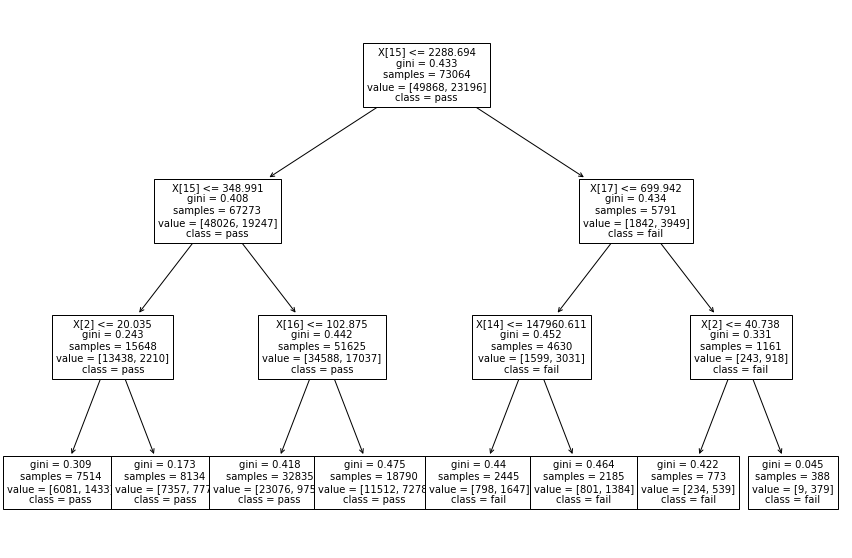

[15 15  2 -2 -2 16 -2 -2 17 14 -2 -2  2 -2 -2]
[ 2.28869427e+03  3.48991342e+02  2.00350280e+01 -2.00000000e+00
 -2.00000000e+00  1.02874747e+02 -2.00000000e+00 -2.00000000e+00
  6.99941550e+02  1.47960611e+05 -2.00000000e+00 -2.00000000e+00
  4.07375903e+01 -2.00000000e+00 -2.00000000e+00]
{'F1': 0.2678251275686112}


[15 11  0  0  0  0  0  0 11  0  0  0  0  0  0]
[ 1112.54238781   157.3003725      0.             0.
     0.             0.             0.             0.
 49567.09667257     0.             0.             0.
     0.             0.             0.        ]
{'F1': 0.2678251275686112}


[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[16945.64647763     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.        ]
{'F1': 0.2678251275686112}


tensor([1.2000e+01, 1.6946e+04])

In [33]:
model = modDecisionTree(max_depth=3)
model.fit(X_train, y_train, df.columns)
# before conv
model.plot_tree()
print(model.features)
print(model.thresholds)
print(model.evaluate(X_val,y_val))
print('\n')
# 1 conv
features, thresholds = model.features.copy(), model.thresholds.copy()
new_features, new_thresholds = tree_convolution(model, features, thresholds)
print(new_features)
print(new_thresholds)
print(model.evaluate(X_val,y_val))
print('\n')
# 2 conv
new_new_features, new_new_thresholds = tree_convolution(model, new_features, new_thresholds)
print(new_new_features)
print(new_new_thresholds)
print(model.evaluate(X_val,y_val))
# state
flatten(new_new_features, new_new_thresholds)

In [34]:
print(model.features)
print(generate_state(model, model.features, model.thresholds, 0))
print(generate_state(model, model.features, model.thresholds, 1))
print(generate_state(model, model.features, model.thresholds, 2))

[15 15  2 -2 -2 16 -2 -2 17 14 -2 -2  2 -2 -2]
tensor([ 1.5000e+01,  1.5000e+01,  2.0000e+00, -2.0000e+00, -2.0000e+00,
         1.6000e+01, -2.0000e+00, -2.0000e+00,  1.7000e+01,  1.4000e+01,
        -2.0000e+00, -2.0000e+00,  2.0000e+00, -2.0000e+00, -2.0000e+00,
         2.2887e+03,  3.4899e+02,  2.0035e+01, -2.0000e+00, -2.0000e+00,
         1.0287e+02, -2.0000e+00, -2.0000e+00,  6.9994e+02,  1.4796e+05,
        -2.0000e+00, -2.0000e+00,  4.0738e+01, -2.0000e+00, -2.0000e+00])
tensor([1.5000e+01, 1.1000e+01, 1.1000e+01, 1.1125e+03, 1.5730e+02, 4.9567e+04])
tensor([1.2000e+01, 1.6946e+04])
